In [1]:
import sys

sys.path.append("../")
from src.qaoa_scheduling import QAOACircuit, QAOAScheduler
import numpy as np

In [2]:
def run_example_comparison(circuit: QAOACircuit, instance_name: str):
    """Run and compare both greedy and LP methods for one circuit instance."""
    print(f"\n{instance_name}")
    print("=" * 50)

    # Print gate times
    print("Gate times:")
    for gate, time in circuit.gamma_gates.items():
        print(f"  γ(Q{gate[0]}-Q{gate[1]}): {time:.2f}")
    print(f"  β (all qubits): {circuit.beta_time:.2f}")

    # Create scheduler
    scheduler = QAOAScheduler(circuit)

    # Print LP model formulation
    print("\nLinear Programming Model:")
    print("=" * 50)
    print(scheduler.get_lp_model())

    # Get greedy solution
    print("\nSolving with Greedy method...")
    greedy_result = scheduler.schedule_greedy()

    # Get LP solution
    print("\nSolving with Linear Programming...")
    lp_result = scheduler.solve_lp()

    # Print comparison
    print("\nResults Comparison:")
    print("=" * 50)

    print("\nGreedy Solution:")
    print(f"Total time before: {greedy_result.total_time_before:.2f}")
    print(f"Total time after: {greedy_result.total_time_after:.2f}")
    print(
        f"Time improvement: {greedy_result.improvement:.2f} "
        f"({greedy_result.improvement/greedy_result.total_time_before:.1%})"
    )

    print("\nGreedy Scheduling layers:")
    for i, layer in enumerate(greedy_result.cost_layers):
        print(f"\nLayer {i+1} (time = {layer.time:.2f}):")
        for gate in layer.gates:
            print(
                f"  Gate Q{gate[0]}-Q{gate[1]}: time = {circuit.gamma_gates[gate]:.2f}"
            )
    print(f"\nMixer layer (time = {greedy_result.mixer_layer.time:.2f})")

    print("\nLP Solution:")
    print(f"Total time before: {lp_result.total_time_before:.2f}")
    print(f"Total time after: {lp_result.total_time_after:.2f}")
    print(
        f"Time improvement: {lp_result.improvement:.2f} "
        f"({lp_result.improvement/lp_result.total_time_before:.1%})"
    )

    print("\nLP Scheduling layers:")
    for i, layer in enumerate(lp_result.cost_layers):
        print(f"\nLayer {i+1} (time = {layer.time:.2f}):")
        for gate in layer.gates:
            print(
                f"  Gate Q{gate[0]}-Q{gate[1]}: time = {circuit.gamma_gates[gate]:.2f}"
            )
    print(f"\nMixer layer (time = {lp_result.mixer_layer.time:.2f})")

    # Compare solutions
    time_diff = greedy_result.total_time_after - lp_result.total_time_after
    print("\nSolution Comparison:")
    print(f"Time difference (Greedy - LP): {time_diff:.2f}")
    if abs(time_diff) < 1e-6:
        print("Both methods found same-quality solution!")
    elif time_diff > 0:
        print(f"LP found better solution by {time_diff:.2f} time units")
    else:
        print(f"Greedy found better solution by {-time_diff:.2f} time units")

    # Visualize both solutions
    print("\nGreedy solution visualization:")
    scheduler.visualize_schedule_comparison(greedy_result)
    print("\nLP solution visualization:")
    scheduler.visualize_schedule_comparison(lp_result)

    return greedy_result, lp_result


def create_random_circuit(
    n_qubits: int,
    gamma_min: float = 0,
    gamma_max: float = 2 * np.pi,
    beta_time: float = 1.0,
    seed=None,
) -> QAOACircuit:
    """Create a cycle graph QAOA circuit with random gamma gate times."""
    if seed is not None:
        np.random.seed(seed)

    gamma_gates = {}
    for i in range(n_qubits):
        gamma_gates[(i, (i + 1) % n_qubits)] = np.round(
            np.random.uniform(gamma_min, gamma_max), 3
        )

    return QAOACircuit(n_qubits=n_qubits, gamma_gates=gamma_gates, beta_time=beta_time)


def analyze_comparison_results(greedy_results, lp_results, circuit_type: str):
    """Analyze results comparing greedy and LP methods."""
    greedy_improvements = [r.improvement / r.total_time_before for r in greedy_results]
    lp_improvements = [r.improvement / r.total_time_before for r in lp_results]

    print(f"\nAnalysis for {circuit_type}:")
    print("=" * 50)
    print("Greedy method:")
    print(f"Average improvement: {np.mean(greedy_improvements):.1%}")
    print(f"Best improvement: {max(greedy_improvements):.1%}")
    print(f"Worst improvement: {min(greedy_improvements):.1%}")
    print(
        f"Average number of layers: {np.mean([len(r.cost_layers) for r in greedy_results]):.1f}"
    )

    print("\nLP method:")
    print(f"Average improvement: {np.mean(lp_improvements):.1%}")
    print(f"Best improvement: {max(lp_improvements):.1%}")
    print(f"Worst improvement: {min(lp_improvements):.1%}")
    print(
        f"Average number of layers: {np.mean([len(r.cost_layers) for r in lp_results]):.1f}"
    )

    # Compare methods
    better_lp = sum(
        1
        for g, l in zip(greedy_results, lp_results)
        if l.total_time_after < g.total_time_after
    )
    better_greedy = sum(
        1
        for g, l in zip(greedy_results, lp_results)
        if g.total_time_after < l.total_time_after
    )
    equal = sum(
        1
        for g, l in zip(greedy_results, lp_results)
        if abs(g.total_time_after - l.total_time_after) < 1e-6
    )

    print(f"\nMethod comparison:")
    print(f"LP better: {better_lp} instances")
    print(f"Greedy better: {better_greedy} instances")
    print(f"Equal quality: {equal} instances")

In [3]:
# C5 example
def example_c5_circuit() -> QAOACircuit:
    n_qubits = 5
    gamma_gates = {(0, 1): 5.0, (1, 2): 4.0, (2, 3): 3.0, (3, 4): 2.0, (4, 0): 1.0}
    return QAOACircuit(n_qubits=n_qubits, gamma_gates=gamma_gates, beta_time=1.0)


# C7 example
def example_c7_circuit() -> QAOACircuit:
    n_qubits = 7
    gamma_gates = {
        (0, 1): 7.0,
        (1, 2): 6.0,
        (2, 3): 5.0,
        (3, 4): 4.0,
        (4, 5): 3.0,
        (5, 6): 2.0,
        (6, 0): 1.0,
    }
    return QAOACircuit(n_qubits=n_qubits, gamma_gates=gamma_gates, beta_time=1.0)

## C5 Example:


C5 Fixed Example:

C5 Fixed
Gate times:
  γ(Q0-Q1): 5.00
  γ(Q1-Q2): 4.00
  γ(Q2-Q3): 3.00
  γ(Q3-Q4): 2.00
  γ(Q4-Q0): 1.00
  β (all qubits): 1.00

Linear Programming Model:
QAOA Circuit with 5 qubits

Gate times:
t_(0, 1) = 5.0
t_(1, 2) = 4.0
t_(2, 3) = 3.0
t_(3, 4) = 2.0
t_(4, 0) = 1.0
t_β = 1.0

Minimize: Z

Subject to:

1. Non-overlapping gates:
x_(0, 1) ≥ x_(1, 2) + 4.0 - M⋅y_(0, 1)(1, 2)
x_(0, 1) ≥ x_(4, 0) + 1.0 - M⋅y_(0, 1)(4, 0)
x_(1, 2) ≥ x_(2, 3) + 3.0 - M⋅y_(1, 2)(2, 3)
x_(2, 3) ≥ x_(3, 4) + 2.0 - M⋅y_(2, 3)(3, 4)
x_(3, 4) ≥ x_(4, 0) + 1.0 - M⋅y_(3, 4)(4, 0)
x_(1, 2) ≥ x_(0, 1) + 5.0 - M⋅(1-y_(0, 1)(1, 2))
x_(4, 0) ≥ x_(0, 1) + 5.0 - M⋅(1-y_(0, 1)(4, 0))
x_(2, 3) ≥ x_(1, 2) + 4.0 - M⋅(1-y_(1, 2)(2, 3))
x_(3, 4) ≥ x_(2, 3) + 3.0 - M⋅(1-y_(2, 3)(3, 4))
x_(4, 0) ≥ x_(3, 4) + 2.0 - M⋅(1-y_(3, 4)(4, 0))

2. Total time:
Z ≥ x_(0, 1) + 5.0 + 1.0
Z ≥ x_(1, 2) + 4.0 + 1.0
Z ≥ x_(2, 3) + 3.0 + 1.0
Z ≥ x_(3, 4) + 2.0 + 1.0
Z ≥ x_(4, 0) + 1.0 + 1.0

3. Variable domains:
x_g ≥ 0 for a

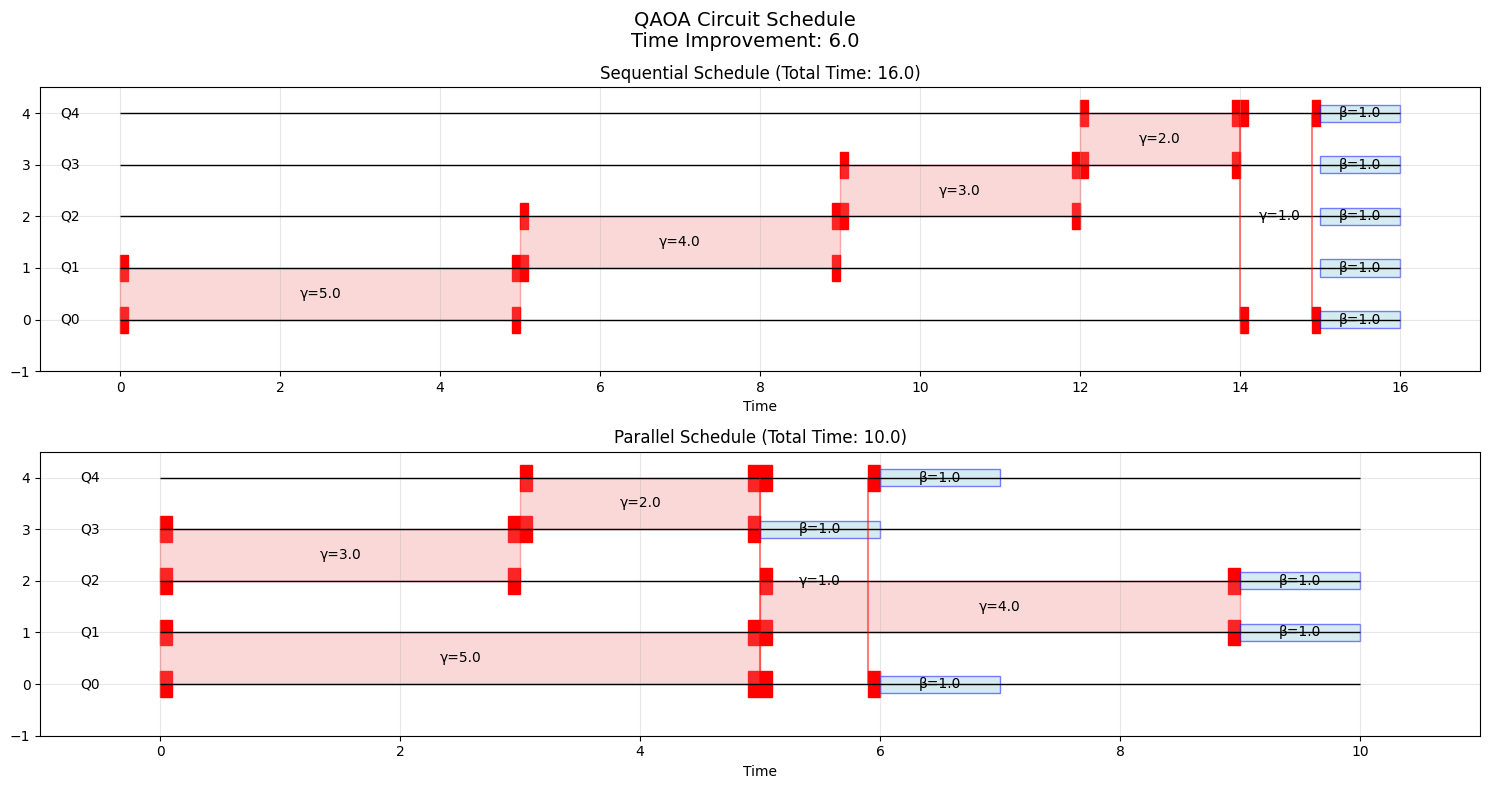


LP solution visualization:


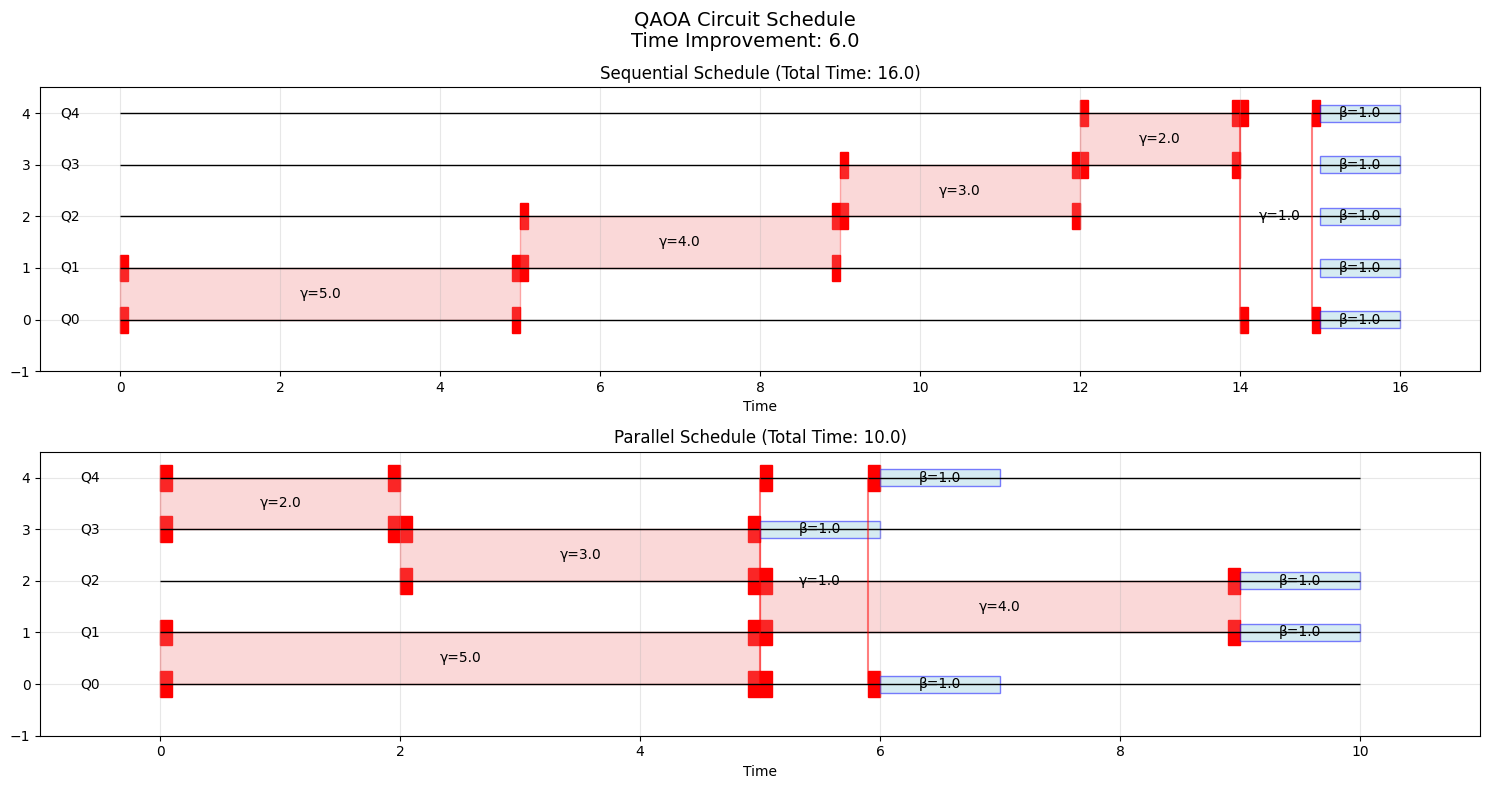

In [4]:
# Run fixed examples
print("\nC5 Fixed Example:")
c5_circuit = example_c5_circuit()
c5_greedy, c5_lp = run_example_comparison(c5_circuit, "C5 Fixed")

## C7 Fixed Example:


C7 Fixed
Gate times:
  γ(Q0-Q1): 7.00
  γ(Q1-Q2): 6.00
  γ(Q2-Q3): 5.00
  γ(Q3-Q4): 4.00
  γ(Q4-Q5): 3.00
  γ(Q5-Q6): 2.00
  γ(Q6-Q0): 1.00
  β (all qubits): 1.00

Linear Programming Model:
QAOA Circuit with 7 qubits

Gate times:
t_(0, 1) = 7.0
t_(1, 2) = 6.0
t_(2, 3) = 5.0
t_(3, 4) = 4.0
t_(4, 5) = 3.0
t_(5, 6) = 2.0
t_(6, 0) = 1.0
t_β = 1.0

Minimize: Z

Subject to:

1. Non-overlapping gates:
x_(0, 1) ≥ x_(1, 2) + 6.0 - M⋅y_(0, 1)(1, 2)
x_(0, 1) ≥ x_(6, 0) + 1.0 - M⋅y_(0, 1)(6, 0)
x_(1, 2) ≥ x_(2, 3) + 5.0 - M⋅y_(1, 2)(2, 3)
x_(2, 3) ≥ x_(3, 4) + 4.0 - M⋅y_(2, 3)(3, 4)
x_(3, 4) ≥ x_(4, 5) + 3.0 - M⋅y_(3, 4)(4, 5)
x_(4, 5) ≥ x_(5, 6) + 2.0 - M⋅y_(4, 5)(5, 6)
x_(5, 6) ≥ x_(6, 0) + 1.0 - M⋅y_(5, 6)(6, 0)
x_(1, 2) ≥ x_(0, 1) + 7.0 - M⋅(1-y_(0, 1)(1, 2))
x_(6, 0) ≥ x_(0, 1) + 7.0 - M⋅(1-y_(0, 1)(6, 0))
x_(2, 3) ≥ x_(1, 2) + 6.0 - M⋅(1-y_(1, 2)(2, 3))
x_(3, 4) ≥ x_(2, 3) + 5.0 - M⋅(1-y_(2, 3)(3, 4))
x_(4, 5) ≥ x_(3, 4) + 4.0 - M⋅(1-y_(3, 4)(4, 5))
x_(5, 6) ≥ x_(4, 5) + 3.0 - M⋅(1-y_(4, 5)

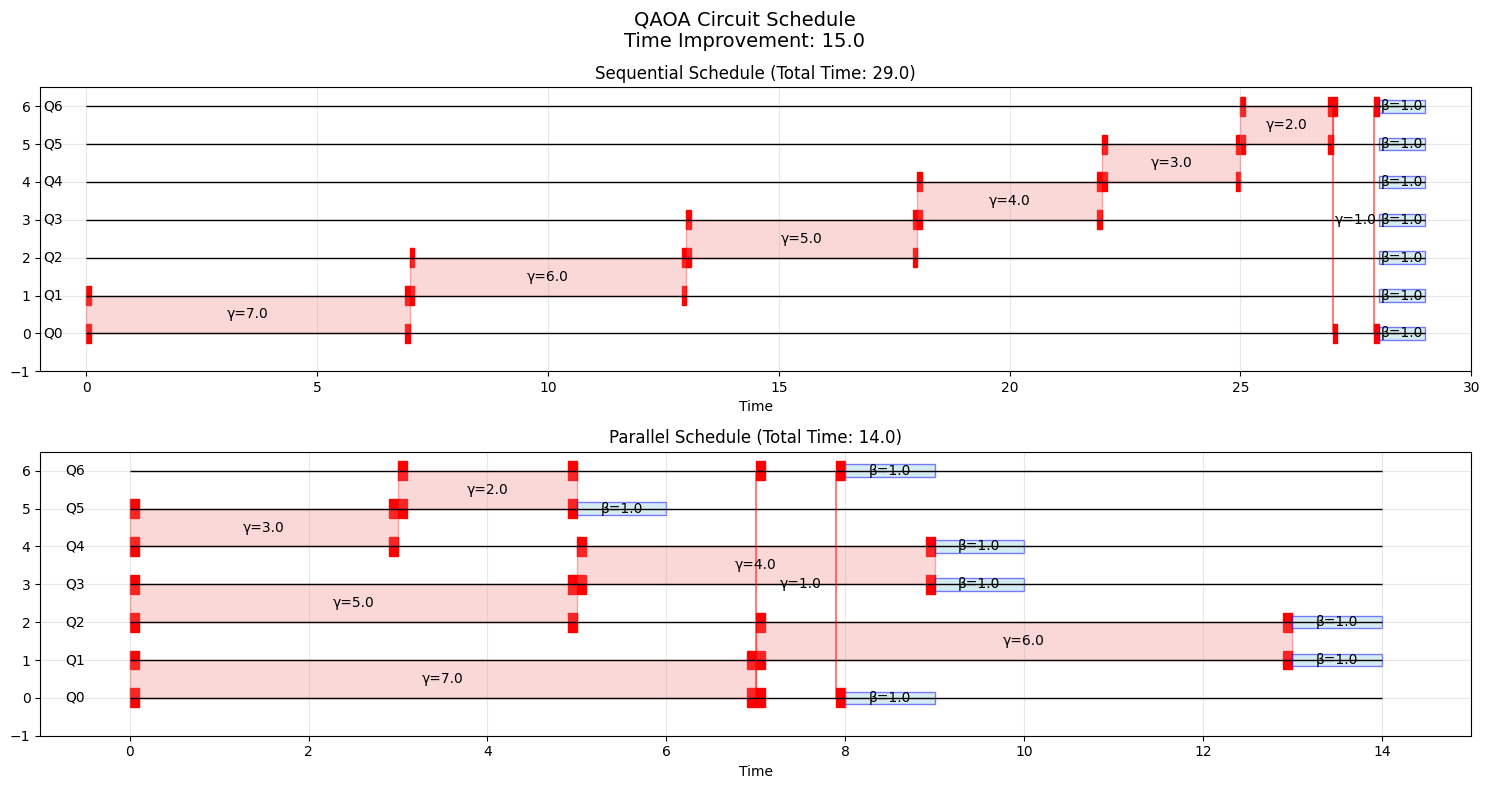


LP solution visualization:


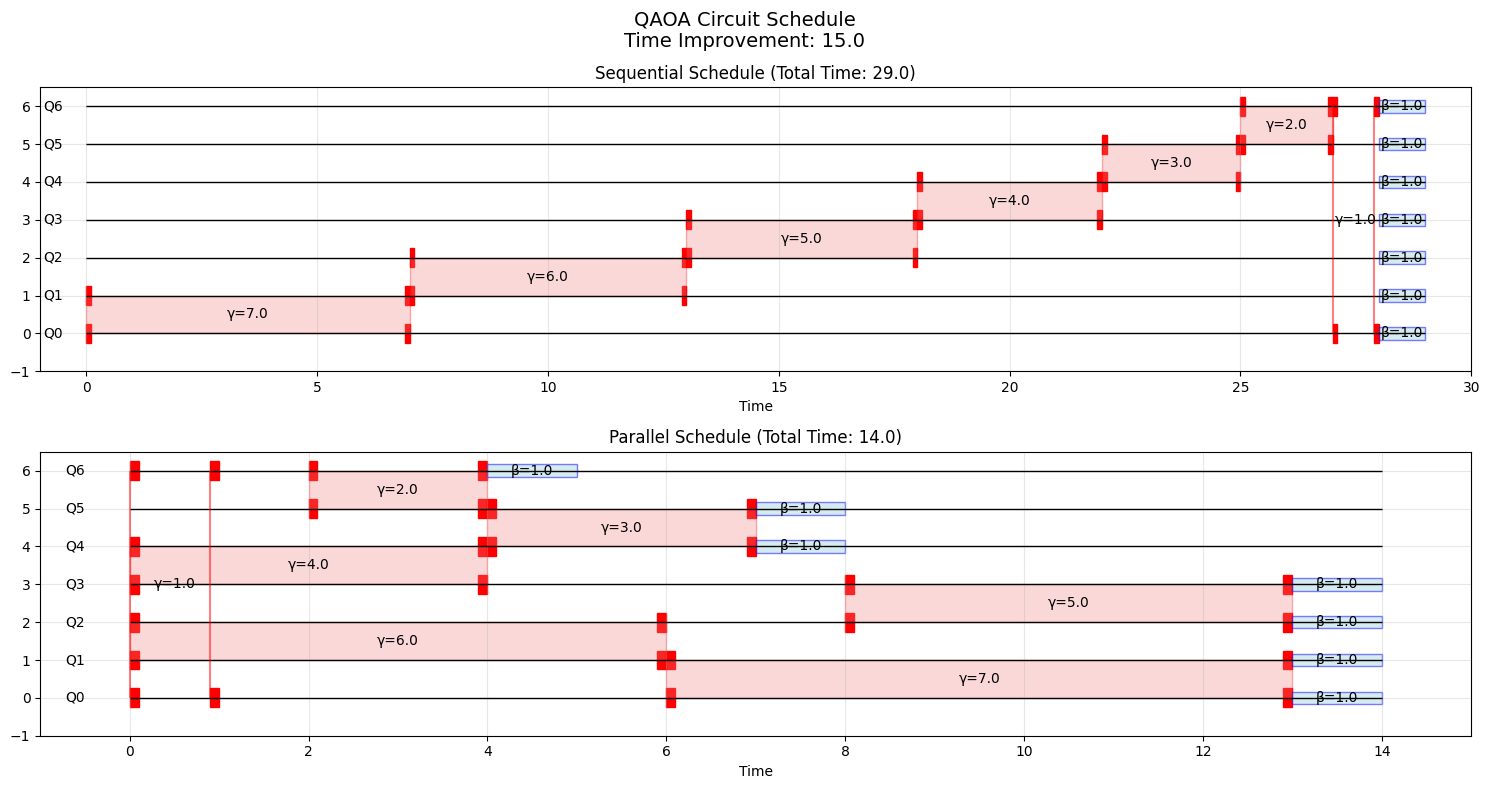

In [5]:
c7_circuit = example_c7_circuit()
c7_greedy, c7_lp = run_example_comparison(c7_circuit, "C7 Fixed")